In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from math import sqrt
from statistics import mode
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
import category_encoders as ce
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

In [2]:
fooddf=pd.read_csv(r"D:\Downloads\train.csv")
centerdf=pd.read_csv(r"D:\Downloads\fulfilment_center_info.csv")
mealdf=pd.read_csv(r"D:\Downloads\meal_info.csv")

In [3]:
hackdf=pd.read_csv(r"D:\Downloads\test_QoiMO9B.csv")
hackdf=pd.merge(hackdf, centerdf, on="center_id", how="left")
hackdf=pd.merge(hackdf, mealdf, on="meal_id", how="left")
hackdf['region_code'] = hackdf['city_code'].astype(str) + "_" + hackdf['region_code'].astype(str)

In [4]:
fooddf=pd.merge(fooddf, centerdf, on="center_id", how="left")
fooddf=pd.merge(fooddf, mealdf, on="meal_id", how="left")

In [ ]:
fooddf.shape

In [ ]:
hackdf.shape

In [ ]:
fooddf['city_code'].nunique()

In [ ]:
stop

In [ ]:
fooddf.isnull().sum()

In [ ]:
fooddf

In [ ]:
fooddf.center_type.unique()

In [ ]:
fooddf.cuisine.unique()

### Cuisine vs Number of Orders

In [ ]:
plt.figure(figsize=(13, 8))
sns.barplot(x="cuisine", y="num_orders", data=fooddf)

### Center Type vs Number of Orders

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x="center_type", y="num_orders", data=fooddf)

In [ ]:
plt.figure(figsize=(16, 10))
sns.distplot(fooddf["num_orders"])

In [ ]:
plt.figure(figsize=(16, 10))
sns.distplot(fooddf["checkout_price"])

### Week vs Number of Orders

In [ ]:
plt.figure(figsize=(15, 10))
ax=sns.barplot(x="week", y="num_orders", data=fooddf)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()

### Price vs Week

In [ ]:
plt.figure(figsize=(15, 10))
ax=sns.barplot(x="week", y="checkout_price", data=fooddf)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()

### Homepage featured vs Number of orders

In [ ]:
sns.barplot(x="homepage_featured", y="num_orders", data=fooddf)

### emailer for promotion vs number of orders

In [ ]:
sns.barplot(x="emailer_for_promotion", y="num_orders", data=fooddf)

### Category vs Checkout Price

In [ ]:
plt.figure(figsize=(13, 8))
sns.barplot(x="category", y="checkout_price", data=fooddf)

### Cuisine vs price

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x="cuisine", y="checkout_price", data=fooddf)

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x="region_code", y="num_orders", data=fooddf)

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x="city_code", y="num_orders", data=fooddf)

In [ ]:
plt.scatter(fooddf.checkout_price, fooddf.num_orders, c = "blue", marker = "s")
plt.title("checkout price vs number of orders")
plt.xlabel("checkout_price")
plt.ylabel("num_orders")
plt.show()

In [ ]:
stop

### Splitting

In [5]:
traindf, testdf = train_test_split(
    fooddf.drop(labels=['id'], axis=1),
    test_size=0.0, shuffle=False,
    random_state=0)

traindf, valdf = train_test_split(
    traindf, 
    test_size=0.0, shuffle=False,
    random_state=0)
traindf.shape, testdf.shape

((456548, 14), (0, 14))

In [6]:
traindf["discount"]=traindf["base_price"]-traindf["checkout_price"]
testdf["discount"]=testdf["base_price"]-testdf["checkout_price"]


In [7]:
traindf = traindf.sort_values(['center_id', 'meal_id', 'week']).reset_index(drop=True)
traindf['last_pre_cp_diff'] = traindf['checkout_price'].shift(1) - traindf['checkout_price']
testdf = testdf.sort_values(['center_id', 'meal_id', 'week']).reset_index(drop=True)
testdf['last_pre_cp_diff'] = testdf['checkout_price'].shift(1) - testdf['checkout_price']


In [8]:
for _, r in traindf.groupby(['center_id', 'meal_id'])['week'].first().reset_index().iterrows():
    traindf.loc[(traindf['center_id']==r['center_id']) & (traindf['meal_id']==r['meal_id']) & (traindf['week']==r['week']), 'last_pre_cp_diff'] = traindf[(traindf['center_id']==r['center_id']) & (traindf['meal_id']==r['meal_id']) & (traindf['week']!=r['week'])]['last_pre_cp_diff'].mean()

In [9]:
for _, r in testdf.groupby(['center_id', 'meal_id'])['week'].first().reset_index().iterrows():
    testdf.loc[(testdf['center_id']==r['center_id']) & (testdf['meal_id']==r['meal_id']) & (testdf['week']==r['week']), 'last_pre_cp_diff'] = testdf[(testdf['center_id']==r['center_id']) & (testdf['meal_id']==r['meal_id']) & (testdf['week']!=r['week'])]['last_pre_cp_diff'].mean()


In [10]:
traindf['price_increase'] = traindf['last_pre_cp_diff'] < 0
testdf['price_increase'] = testdf['last_pre_cp_diff'] < 0


In [11]:
traindf['high_price_che_than_base'] = traindf['discount'] < 0
testdf['high_price_che_than_base'] = testdf['discount'] < 0


In [12]:
traindf[traindf['last_pre_cp_diff'].isnull()]

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,discount,last_pre_cp_diff,price_increase,high_price_che_than_base
305123,85,101,1571,581.03,583.03,0,0,14,699,85,TYPE_C,2.8,Fish,Continental,2.0,NaN,False,False
395109,134,145,1571,602.43,601.43,0,0,42,620,77,TYPE_A,3.9,Fish,Continental,-1.0,NaN,False,True
396490,131,145,2104,437.53,435.53,0,0,68,620,77,TYPE_A,3.9,Fish,Continental,-2.0,NaN,False,True


In [13]:
traindf['last_pre_cp_diff'] = traindf['last_pre_cp_diff'].fillna(0)
testdf['last_pre_cp_diff'] = testdf['last_pre_cp_diff'].fillna(0)


In [14]:
traindf['discount_on_base'] = (traindf['base_price'] - traindf['checkout_price']) / traindf['base_price']
testdf['discount_on_base'] = (testdf['base_price'] - testdf['checkout_price']) / testdf['base_price']


In [15]:
traindf['neg_discount'] = (traindf['discount_on_base'] < 0).astype(int)
testdf['neg_discount'] = (testdf['discount_on_base'] < 0).astype(int)


In [16]:
traindf['price_last_curr_diff'] = (traindf['checkout_price'].shift(1) - traindf['checkout_price']).fillna(1)/ traindf['checkout_price'].shift(1).fillna(1)
testdf['price_last_curr_diff'] = (testdf['checkout_price'].shift(1) - testdf['checkout_price']).fillna(1)/ testdf['checkout_price'].shift(1).fillna(1)


In [17]:
for _, r in traindf.groupby(['center_id', 'meal_id'])['week'].first().reset_index().iterrows():
    traindf.loc[(traindf['center_id']==r['center_id']) & (traindf['meal_id']==r['meal_id']) & (traindf['week']==r['week']), 'price_last_curr_diff'] = traindf[(traindf['center_id']==r['center_id']) & (traindf['meal_id']==r['meal_id']) & (traindf['week']!=r['week'])]['price_last_curr_diff'].mean()
for _, r in testdf.groupby(['center_id', 'meal_id'])['week'].first().reset_index().iterrows():
    testdf.loc[(testdf['center_id']==r['center_id']) & (testdf['meal_id']==r['meal_id']) & (testdf['week']==r['week']), 'price_last_curr_diff'] = testdf[(testdf['center_id']==r['center_id']) & (testdf['meal_id']==r['meal_id']) & (testdf['week']!=r['week'])]['price_last_curr_diff'].mean()


In [18]:
traindf['price_last_curr_diff'] = traindf['price_last_curr_diff'].fillna(0)
traindf['price_increase'] = (traindf['price_last_curr_diff'] < 0).astype(int)
testdf['price_last_curr_diff'] = testdf['price_last_curr_diff'].fillna(0)
testdf['price_increase'] = (testdf['price_last_curr_diff'] < 0).astype(int)


In [19]:
# Monthwise aggregated sales values
def create_sales_agg_monthwise_features(df, gpby_cols, target_col, agg_funcs):
    '''
    Creates various sales agg features with given agg functions  
    '''
    gpby = df.groupby(gpby_cols)
    newdf = df[gpby_cols].drop_duplicates().reset_index(drop=True)
    for agg_name, agg_func in agg_funcs.items():
        aggdf = gpby[target_col].agg(agg_func).reset_index()
        aggdf.rename(columns={target_col:target_col+'_'+agg_name}, inplace=True)
        newdf = newdf.merge(aggdf, on=gpby_cols, how='left')
    return newdf

In [20]:
# Features constructed from previous sales values

#Creating sales lag features
def create_sales_lag_feats(df, gpby_cols, target_col, lags):
    gpby = df.groupby(gpby_cols)
    for i in lags:
        df['_'.join([target_col, 'lag', str(i)])] = \
                gpby[target_col].shift(i).values + np.random.normal(scale=1.6, size=(len(df),))
    return df

# Creating sales rolling mean features
def create_sales_rmean_feats(df, gpby_cols, target_col, windows, min_periods=2, 
                             shift=1, win_type=None):
    gpby = df.groupby(gpby_cols)
    for w in windows:
        df['_'.join([target_col, 'rmean', str(w)])] = \
            gpby[target_col].shift(shift).rolling(window=w, 
                                                  min_periods=min_periods,
                                                  win_type=win_type).mean().values +\
            np.random.normal(scale=1.6, size=(len(df),))
    return df


# Creating sales rolling median features
def create_sales_rmed_feats(df, gpby_cols, target_col, windows, min_periods=2, 
                            shift=1, win_type=None):
    gpby = df.groupby(gpby_cols)
    for w in windows:
        df['_'.join([target_col, 'rmed', str(w)])] = \
            gpby[target_col].shift(shift).rolling(window=w, 
                                                  min_periods=min_periods,
                                                  win_type=win_type).median().values +\
            np.random.normal(scale=1.6, size=(len(df),))
    return df

# Creating sales exponentially weighted mean features
def create_sales_ewm_feats(df, gpby_cols, target_col, alpha=[0.9], shift=[1]):
    gpby = df.groupby(gpby_cols)
    for a in alpha:
        for s in shift:
            df['_'.join([target_col, 'lag', str(s), 'ewm', str(a)])] = \
                gpby[target_col].shift(s).ewm(alpha=a).mean().values
    return df

In [21]:
# # Creating num_orders lag, rolling mean, rolling median, ohe features of the above train set
traindf = create_sales_lag_feats(traindf, gpby_cols=['center_id','meal_id'], target_col='num_orders', 
                               lags=[10,11,12,13,14,15,26,27,28,29])

traindf = create_sales_rmean_feats(traindf, gpby_cols=['center_id','meal_id'], 
                                 target_col='num_orders', windows=[26,52,104], 
                                 min_periods=3, win_type='triang')

traindf = create_sales_rmed_feats(traindf, gpby_cols=['center_id','meal_id'], 
                                 target_col='num_orders', windows=[26,52,104], 
                                 min_periods=3, win_type=None)

traindf = create_sales_ewm_feats(traindf, gpby_cols=['center_id','meal_id'], 
                               target_col='num_orders', 
                               alpha=[0.95, 0.9, 0.8, 0.7, 0.6, 0.5], 
                               shift=[10,11,12,13,14,15,26,27,28,29])

In [22]:
# # Creating num_orders lag, rolling mean, rolling median, ohe features of the above train set
testdf = create_sales_lag_feats(testdf, gpby_cols=['center_id','meal_id'], target_col='num_orders', 
                               lags=[10,11,12,13,14,15,26,27,28,29])

testdf = create_sales_rmean_feats(testdf, gpby_cols=['center_id','meal_id'], 
                                 target_col='num_orders', windows=[26,52,104], 
                                 min_periods=3, win_type='triang')

testdf = create_sales_rmed_feats(testdf, gpby_cols=['center_id','meal_id'], 
                                 target_col='num_orders', windows=[26,52,104], 
                                 min_periods=3, win_type=None)

testdf = create_sales_ewm_feats(testdf, gpby_cols=['center_id','meal_id'], 
                               target_col='num_orders', 
                               alpha=[0.95, 0.9, 0.8, 0.7, 0.6, 0.5], 
                               shift=[10,11,12,13,14,15,26,27,28,29])

In [23]:
traindf['week_sin'] = np.sin(2 * np.pi * traindf['week'] / 52.143)
traindf['week_cos'] = np.cos(2 * np.pi * traindf['week'] / 52.143)

In [24]:
testdf['week_sin'] = np.sin(2 * np.pi * testdf['week'] / 52.143)
testdf['week_cos'] = np.cos(2 * np.pi * testdf['week'] / 52.143)


In [25]:
traindf['email_plus_homepage'] = traindf['emailer_for_promotion'] + traindf['homepage_featured']

In [26]:
testdf['email_plus_homepage'] = testdf['emailer_for_promotion'] + testdf['homepage_featured']


In [27]:
traindf[traindf.columns[1:]].corr().abs()['num_orders'][:]

center_id                    0.053035
meal_id                      0.010597
checkout_price               0.282108
base_price                   0.222306
emailer_for_promotion        0.277147
homepage_featured            0.294490
num_orders                   1.000000
city_code                    0.041596
region_code                  0.029744
op_area                      0.176976
discount                     0.152950
last_pre_cp_diff             0.140187
price_increase               0.022599
high_price_che_than_base     0.051871
discount_on_base             0.205188
neg_discount                 0.051871
price_last_curr_diff         0.087574
num_orders_lag_10            0.538952
num_orders_lag_11            0.540959
num_orders_lag_12            0.542767
num_orders_lag_13            0.503506
num_orders_lag_14            0.504814
num_orders_lag_15            0.500957
num_orders_lag_26            0.492441
num_orders_lag_27            0.484208
num_orders_lag_28            0.505870
num_orders_l

In [28]:
traindf[traindf.isna().any(axis=1)]

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,...,num_orders_lag_13_ewm_0.5,num_orders_lag_14_ewm_0.5,num_orders_lag_15_ewm_0.5,num_orders_lag_26_ewm_0.5,num_orders_lag_27_ewm_0.5,num_orders_lag_28_ewm_0.5,num_orders_lag_29_ewm_0.5,week_sin,week_cos,email_plus_homepage
0,1,10,1062,181.39,181.39,0,0,865,590,56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.120208,0.992749,0
1,2,10,1062,183.36,182.36,0,0,782,590,56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.238672,0.971100,0
2,3,10,1062,184.36,182.36,0,0,851,590,56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.353675,0.935368,0
3,4,10,1062,182.36,183.36,0,0,1202,590,56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.463549,0.886071,0
4,5,10,1062,183.39,181.39,0,0,958,590,56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.566700,0.823924,0
5,6,10,1062,162.05,183.39,0,0,1094,590,56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.661633,0.749828,0
6,7,10,1062,160.08,183.39,0,0,1513,590,56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.746971,0.664857,0
7,8,10,1062,160.05,182.39,0,0,1149,590,56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.821475,0.570244,0
8,9,10,1062,162.05,182.39,0,0,1282,590,56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.884066,0.467362,0
9,10,10,1062,161.05,181.39,0,0,1473,590,56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.933836,0.357701,0


Fill with respective column mean?

### Mean num orders vs categories

In [29]:
mean_num_orders_week_map=dict(traindf.groupby(['week']).num_orders.agg(["mean"])["mean"].round(6))
traindf["mean_num_orders_week"]=traindf["week"].map(mean_num_orders_week_map)
testdf["mean_num_orders_week"]=testdf["week"].map(mean_num_orders_week_map)
testdf["mean_num_orders_week"].fillna(np.nanmean(list(mean_num_orders_week_map.values())).round(), inplace=True)

Series([], Name: mean_num_orders_week, dtype: float64)

In [30]:
mean_num_orders_cuisine_map=dict(traindf.groupby(['cuisine']).num_orders.agg(["mean"])["mean"].round(6))
traindf["mean_num_orders_cuisine"]=traindf["cuisine"].map(mean_num_orders_cuisine_map)
testdf["mean_num_orders_cuisine"]=testdf["cuisine"].map(mean_num_orders_cuisine_map)

In [31]:
mean_num_orders_city_code_map=dict(traindf.groupby(['city_code']).num_orders.agg(["mean"])["mean"].round(6))
traindf["mean_num_orders_city_code"]=traindf["city_code"].map(mean_num_orders_city_code_map)
testdf["mean_num_orders_city_code"]=testdf["city_code"].map(mean_num_orders_city_code_map)

In [32]:
mean_num_orders_region_code_map=dict(traindf.groupby(['region_code']).num_orders.agg(["mean"])["mean"].round(6))
traindf["mean_num_orders_region_code"]=traindf["region_code"].map(mean_num_orders_region_code_map)
testdf["mean_num_orders_region_code"]=testdf["region_code"].map(mean_num_orders_region_code_map)

In [33]:
mean_num_orders_center_type_map=dict(traindf.groupby(['center_type']).num_orders.agg(["mean"])["mean"].round(6))
traindf["mean_num_orders_center_type"]=traindf["center_type"].map(mean_num_orders_center_type_map)
testdf["mean_num_orders_center_type"]=testdf["center_type"].map(mean_num_orders_center_type_map)

In [34]:
mean_num_orders_category_map=dict(traindf.groupby(['category']).num_orders.agg(["mean"])["mean"].round(6))
traindf["mean_num_orders_category"]=traindf["category"].map(mean_num_orders_category_map)
testdf["mean_num_orders_category"]=testdf["category"].map(mean_num_orders_category_map)

In [35]:
mean_num_orders_op_area_map=dict(traindf.groupby(['op_area']).num_orders.agg(["mean"])["mean"].round(6))
traindf["mean_num_orders_op_area"]=traindf["op_area"].map(mean_num_orders_op_area_map)
testdf["mean_num_orders_op_area"]=testdf["op_area"].map(mean_num_orders_op_area_map)

In [36]:
mean_num_orders_homepage_featured_map=dict(traindf.groupby(['homepage_featured']).num_orders.agg(["mean"])["mean"].round(6))
traindf["mean_num_orders_homepage_featured"]=traindf["homepage_featured"].map(mean_num_orders_homepage_featured_map)
testdf["mean_num_orders_homepage_featured"]=testdf["homepage_featured"].map(mean_num_orders_homepage_featured_map)

In [37]:
mean_num_orders_emailer_for_promotion_map=dict(traindf.groupby(['emailer_for_promotion']).num_orders.agg(["mean"])["mean"].round(6))
traindf["mean_num_orders_emailer_for_promotion"]=traindf["emailer_for_promotion"].map(mean_num_orders_emailer_for_promotion_map)
testdf["mean_num_orders_emailer_for_promotion"]=testdf["emailer_for_promotion"].map(mean_num_orders_emailer_for_promotion_map)

In [38]:
traindf["cuisine_category"]=traindf["cuisine"]+ "_" + traindf["category"]
cuisine_category_map=dict(traindf.groupby(['cuisine_category']).num_orders.agg(["mean"])["mean"].round(6))
traindf["cuisine_category_num_orders"]=traindf["cuisine_category"].map(cuisine_category_map)
testdf["cuisine_category"]=testdf["cuisine"]+ "_" + testdf["category"]
testdf["cuisine_category_num_orders"]=testdf["cuisine_category"].map(cuisine_category_map)

### checkout price vs categories

In [39]:
mean_checkout_price_cuisine_map=dict(traindf.groupby(['cuisine']).checkout_price.agg(["mean"])["mean"].round(6))
traindf["mean_checkout_price_cuisine"]=traindf["cuisine"].map(mean_checkout_price_cuisine_map)
testdf["mean_checkout_price_cuisine"]=testdf["cuisine"].map(mean_checkout_price_cuisine_map)

In [40]:
mean_checkout_price_category_map=dict(traindf.groupby(['category']).checkout_price.agg(["mean"])["mean"].round(6))
traindf["mean_checkout_price_category"]=traindf["category"].map(mean_checkout_price_category_map)
testdf["mean_checkout_price_category"]=testdf["category"].map(mean_checkout_price_category_map)

### Difference disc

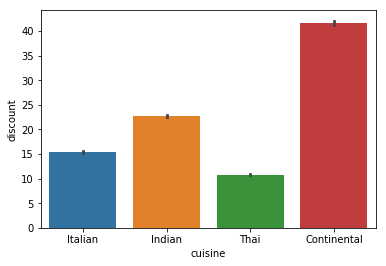

In [41]:
sns.barplot(x="cuisine", y="discount", data=traindf)

In [42]:
mean_discount_category_map=dict(traindf.groupby(['cuisine']).discount.agg(["mean"])["mean"].round(6))
traindf["mean_discount_category"]=traindf["cuisine"].map(mean_discount_category_map)
testdf["mean_discount_category"]=testdf["cuisine"].map(mean_discount_category_map)

### Intentional encode

In [43]:
fooddf.groupby("city_code").num_orders.agg(["mean"]).sort_values(by="mean")

,mean
city_code,
478,126.972117
702,131.277356
658,145.581828
649,153.216715
693,160.611195
541,170.631637
515,175.812979
561,175.968868
632,177.447657


In [44]:
fooddf.dtypes

id                         int64
week                       int64
center_id                  int64
meal_id                    int64
checkout_price           float64
base_price               float64
emailer_for_promotion      int64
homepage_featured          int64
num_orders                 int64
city_code                  int64
region_code                int64
center_type               object
op_area                  float64
category                  object
cuisine                   object
dtype: object

In [45]:
# cuisine_map={'Continental': 16, 'Indian': 22, 'Thai': 27, 'Italian':35 }
# center_type_map={'TYPE_C': 20, 'TYPE_A': 26, 'TYPE_B':31}
# category_map={'Biryani': 3, 'Pasta': 5, 'Desert': 6, 'Soup':8, 'Fish': 9, 'Seafood': 10, 'Starters': 15,
# 'Other Snacks': 16,'Pizza': 22,'Extras':29,'Beverages':31,'Salad': 38,
# 'Sandwich': 52,'Rice Bowl':62}
# region_code_map={35: 131, 34: 206, 77:216, 93: 238, 23: 250, 85:286,56: 316, 71: 334}
# city_code_map = {478:126, 
#                 702:131, 
#                 658:145, 
#                 649:153, 
#                 693:160,
#                 541:170,
#                 515:176, 561:176,632:176,676:176,  
#                 553:180, 562:180, 
#                 593:190, 
#                 695:192, 683:192, 
#                 654:197, 
#                 576:200, 615:200,461:200,
#                 473:209, 526:209, 
#                 675: 237, 556: 237, 609:237, 
#                 517:245,680:245,
#                 698:252,522:252,
#                 485:256,620:256,
#                 599:264, 699:264,
#                 659:270, 604:270, 648:270,
#                 647:276, 614: 276,
#                 456:290, 651:290, 577:290, 703:290,
#                 628:307, 602:307,
#                 579:330, 638:330,596:330, 713:330,
#                 590:362,
#                 700:409, 679:409,
#                 685:447}

In [46]:
traindf['Month'] = traindf['week'].apply(lambda x: ((x // 4)%12))
traindf['Year'] = traindf['week'].apply(lambda x: (x // 52)%2)
traindf['Quarter'] = traindf['week'].apply(lambda x: (x // 13)%4)

In [47]:
testdf['Month'] = testdf['week'].apply(lambda x: ((x // 4)%12))
testdf['Year'] = testdf['week'].apply(lambda x: ((x // 52)%2))
testdf['Quarter'] = testdf['week'].apply(lambda x: ((x // 13)%4))

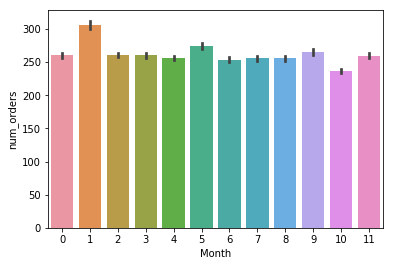

In [48]:
sns.barplot(x="Month", y="num_orders", data=traindf)

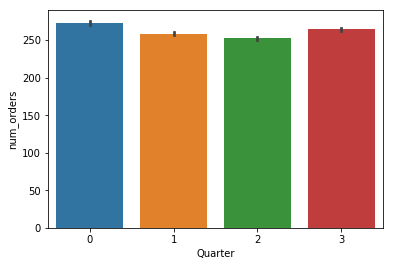

In [49]:
sns.barplot(x="Quarter", y="num_orders", data=traindf)

In [50]:
# sns.barplot(x="Year", y="num_orders", data=traindf)

In [51]:
i=0
for col in traindf.columns:
    print(i, col)
    i=i+1

0 week
1 center_id
2 meal_id
3 checkout_price
4 base_price
5 emailer_for_promotion
6 homepage_featured
7 num_orders
8 city_code
9 region_code
10 center_type
11 op_area
12 category
13 cuisine
14 discount
15 last_pre_cp_diff
16 price_increase
17 high_price_che_than_base
18 discount_on_base
19 neg_discount
20 price_last_curr_diff
21 num_orders_lag_10
22 num_orders_lag_11
23 num_orders_lag_12
24 num_orders_lag_13
25 num_orders_lag_14
26 num_orders_lag_15
27 num_orders_lag_26
28 num_orders_lag_27
29 num_orders_lag_28
30 num_orders_lag_29
31 num_orders_rmean_26
32 num_orders_rmean_52
33 num_orders_rmean_104
34 num_orders_rmed_26
35 num_orders_rmed_52
36 num_orders_rmed_104
37 num_orders_lag_10_ewm_0.95
38 num_orders_lag_11_ewm_0.95
39 num_orders_lag_12_ewm_0.95
40 num_orders_lag_13_ewm_0.95
41 num_orders_lag_14_ewm_0.95
42 num_orders_lag_15_ewm_0.95
43 num_orders_lag_26_ewm_0.95
44 num_orders_lag_27_ewm_0.95
45 num_orders_lag_28_ewm_0.95
46 num_orders_lag_29_ewm_0.95
47 num_orders_lag_10_ewm

In [52]:
traindf.dtypes

week                                       int64
center_id                                  int64
meal_id                                    int64
checkout_price                           float64
base_price                               float64
emailer_for_promotion                      int64
homepage_featured                          int64
num_orders                                 int64
city_code                                  int64
region_code                                int64
center_type                               object
op_area                                  float64
category                                  object
cuisine                                   object
discount                                 float64
last_pre_cp_diff                         float64
price_increase                             int32
high_price_che_than_base                    bool
discount_on_base                         float64
neg_discount                               int32
price_last_curr_diff

### One Hot Encoding

In [53]:
traindf.loc[traindf["discount"]<0, "discount_category"]=0
traindf.loc[traindf["discount"]>=0, "discount_category"]=2

In [54]:
testdf['discount_category']=np.nan
testdf["discount"]=testdf["base_price"]-testdf["checkout_price"]
testdf.loc[testdf["discount"]<0, "discount_category"]=0
testdf.loc[testdf["discount"]>=0, "discount_category"]=2

In [55]:
categorical_feature_mask = traindf.dtypes==object
categorical_cols = traindf.columns[categorical_feature_mask].tolist()
categorical_cols

['center_type', 'category', 'cuisine', 'cuisine_category']

In [57]:
x_train=pd.get_dummies(data=traindf,columns=['city_code', 'category', 'cuisine', 'center_type',  "region_code", "cuisine_category"])

In [ ]:
x_test=pd.get_dummies(data=testdf,columns=['city_code', 'category', 'cuisine', 'center_type', "city_region" , "region_code", "cuisine_category"])


In [ ]:
x_train.shape

In [ ]:
x_test.shape

In [ ]:
x_train['high_price_che_than_base'].dtypes

In [ ]:
x_train.isnull().sum()

In [ ]:
x_train[x_train.isna().any(axis=1)]

#x_train=traindf.copy(deep=True)
x_train.drop(labels=["num_orders"], inplace=True, axis=1)
y_train=traindf.iloc[:,7]
x_train["category"]=x_train["category"].map(category_map)
x_train["cuisine"]=x_train["cuisine"].map(cuisine_map)
x_train["center_type"]=x_train["center_type"].map(center_type_map)
x_train["region_code"]=x_train["region_code"].map(region_code_map)
x_train["city_code"]=x_train["city_code"].map(city_code_map)
#encoder = ce.OneHotEncoder(cols=['city_code', 'category', 'cuisine', 'center_type', 'region_code'])
#encoder.fit(x_train, y_train)
#x_train = encoder.transform(x_train)

In [ ]:
traindf.shape

x_test=testdf.copy(deep=True)
x_test.drop(labels=["num_orders","cuisine_category"], inplace=True, axis=1)
y_test=testdf.iloc[:,7] 
x_test["category"]=x_test["category"].map(category_map)
#x_test["cuisine"]=x_test["cuisine"].map(cuisine_map)
#x_test["center_type"]=x_test["center_type"].map(center_type_map)
#x_test["region_code"]=x_test["region_code"].map(region_code_map)
x_test["city_code"]=x_test["city_code"].map(city_code_map)


encoder = ce.OneHotEncoder(cols=['city_code', 'category', 'cuisine', 'center_type', 'region_code'])
encoder.fit(x_test)
x_test = encoder.transform(x_test)

In [ ]:
x_test.shape

In [ ]:
x_train['discount_category'].unique()

In [ ]:
i=0
for col in x_hack.columns:
    print(i, col)
    i=i+1

In [ ]:
i=0
for col in x_train.columns:
    print(i, col)
    i=i+1

In [ ]:
# scale= StandardScaler()
# x_train=scale.fit_transform(x_train)
# x_test=scale.fit_transform(x_test)

In [ ]:
x_train.shape

In [ ]:
object_vars = list(x_train.select_dtypes(include=object).columns)
object_vars

In [ ]:
traindf

In [ ]:
y_train=x_train.iloc[:,7]

In [ ]:
x_train.shape

In [ ]:
x_train.drop(labels=["num_orders", "center_id", "meal_id", "Year"],axis=1,inplace=True)
# x_test=dgt.drop(labels=["num_orders", "center_id", "meal_id", "cuisine_homepage_featured_mean","Year", "category_homepage_featured_discount_sum", "category_emailer_for_promotion"], axis=1)
# y_test=dgt["num_orders"]
# y_train=dg["num_orders"]

In [ ]:
features=x_train.columns

In [ ]:
from sklearn.preprocessing import Imputer
imp=Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imp=imp.fit(x_train)
x_train=imp.transform(x_train)
x_train=pd.DataFrame(x_train,columns=features)

In [ ]:
x_train.shape

In [ ]:
valdf['discount_category']=np.nan
valdf["discount"]=valdf["base_price"]-valdf["checkout_price"]
valdf.loc[valdf["discount"]<0, "discount_category"]=0
valdf.loc[valdf["discount"]>=0, "discount_category"]=2
valdf = valdf.sort_values(['center_id', 'meal_id', 'week']).reset_index(drop=True)
valdf['last_pre_cp_diff'] = valdf['checkout_price'].shift(1) - valdf['checkout_price']
for _, r in valdf.groupby(['center_id', 'meal_id'])['week'].first().reset_index().iterrows():
    valdf.loc[(valdf['center_id']==r['center_id']) & (valdf['meal_id']==r['meal_id']) & (valdf['week']==r['week']), 'last_pre_cp_diff'] = valdf[(valdf['center_id']==r['center_id']) & (valdf['meal_id']==r['meal_id']) & (valdf['week']!=r['week'])]['last_pre_cp_diff'].mean()
valdf['price_increase'] = valdf['last_pre_cp_diff'] < 0
valdf['high_price_che_than_base'] = valdf['discount'] < 0
valdf['last_pre_cp_diff'] = valdf['last_pre_cp_diff'].fillna(0)
valdf['discount_on_base'] = (valdf['base_price'] - valdf['checkout_price']) / valdf['base_price']
valdf['neg_discount'] = (valdf['discount_on_base'] < 0).astype(int)
valdf['price_last_curr_diff'] = (valdf['checkout_price'].shift(1) -valdf['checkout_price']).fillna(1)/valdf['checkout_price'].shift(1).fillna(1)
for _, r in valdf.groupby(['center_id', 'meal_id'])['week'].first().reset_index().iterrows():
    valdf.loc[(valdf['center_id']==r['center_id']) & (valdf['meal_id']==r['meal_id']) & (valdf['week']==r['week']), 'price_last_curr_diff'] = valdf[(valdf['center_id']==r['center_id']) & (valdf['meal_id']==r['meal_id']) & (valdf['week']!=r['week'])]['price_last_curr_diff'].mean()
valdf['price_last_curr_diff'] = valdf['price_last_curr_diff'].fillna(0)
valdf['price_increase'] = (valdf['price_last_curr_diff'] < 0).astype(int)
# # Creating num_orders lag, rolling mean, rolling median, ohe features of the above train set
valdf = create_sales_lag_feats(valdf, gpby_cols=['center_id','meal_id'], target_col='num_orders', 
                               lags=[10,11,12,13,14,15,26,27,28,29])

valdf = create_sales_rmean_feats(valdf, gpby_cols=['center_id','meal_id'], 
                                 target_col='num_orders', windows=[26,52,104], 
                                 min_periods=3, win_type='triang')

valdf = create_sales_rmed_feats(valdf, gpby_cols=['center_id','meal_id'], 
                                 target_col='num_orders', windows=[26,52,104], 
                                 min_periods=3, win_type=None)

valdf = create_sales_ewm_feats(valdf, gpby_cols=['center_id','meal_id'], 
                               target_col='num_orders', 
                               alpha=[0.95, 0.9, 0.8, 0.7, 0.6, 0.5], 
                               shift=[10,11,12,13,14,15,26,27,28,29])
valdf.drop(['num_orders'],axis=1,inplace=True)
valdf['week_sin'] = np.sin(2 * np.pi * valdf['week'] / 52.143)
valdf['week_cos'] = np.cos(2 * np.pi * valdf['week'] / 52.143)
valdf['city_region'] = \
        valdf['city_code'].astype('str') + '_' + \
        valdf['region_code'].astype('str')
valdf['email_plus_homepage'] = valdf['emailer_for_promotion'] + valdf['homepage_featured']
valdf["mean_num_orders_week"]=np.nan
valdf["mean_num_orders_week"].fillna((np.nanmean(list(mean_num_orders_week_map.values())).round()), inplace=True)
valdf["cuisine_category"]=valdf["cuisine"]+"_"+valdf["category"]
valdf["mean_num_orders_cuisine"]=valdf["cuisine"].map(mean_num_orders_cuisine_map)
valdf["mean_num_orders_city_code"]=valdf["city_code"].map(mean_num_orders_city_code_map)
valdf["mean_num_orders_region_code"]=valdf["region_code"].map(mean_num_orders_region_code_map)
valdf["mean_num_orders_center_type"]=valdf["center_type"].map(mean_num_orders_center_type_map)
valdf["mean_num_orders_category"]=valdf["category"].map(mean_num_orders_category_map)
valdf["mean_num_orders_op_area"]=valdf["op_area"].map(mean_num_orders_op_area_map)
valdf["mean_num_orders_homepage_featured"]=valdf["homepage_featured"].map(mean_num_orders_homepage_featured_map)
valdf["mean_num_orders_emailer_for_promotion"]=valdf["emailer_for_promotion"].map(mean_num_orders_emailer_for_promotion_map)
valdf["cuisine_category_num_orders"]=valdf["cuisine_category"].map(cuisine_category_map)
valdf["mean_checkout_price_cuisine"]=valdf["cuisine"].map(mean_checkout_price_cuisine_map)
valdf["mean_checkout_price_category"]=valdf["category"].map(mean_checkout_price_category_map)
valdf["mean_discount_category"]=valdf["category"].map(mean_checkout_price_category_map)
valdf['Month'] = valdf['week'].apply(lambda x: ((x // 4)%12))
valdf['Year'] = valdf['week'].apply(lambda x: ((x // 52)%2))
valdf['Quarter'] = valdf['week'].apply(lambda x: ((x // 13)%4))
x_val=pd.get_dummies(data=valdf,columns=['city_code', 'category', 'cuisine', 'center_type', "city_region" , "region_code", "cuisine_category"])

### Random Forest Regressor

In [ ]:
rf=RandomForestRegressor(max_depth= 10, min_samples_split= 6, n_estimators= 500, max_features='auto',min_samples_leaf=5)

In [ ]:
rf.fit(x_train, y_train)

In [ ]:
y_pred_rf = rf.predict(x_test)
print ('Root Mean-squared error on test', sqrt(mean_squared_error(y_pred_rf, y_test)))
print ('Root Mean-squared logarithmic error on test', rmsle(y_test, y_pred_rf))

In [ ]:
y_pred_rf = rf.predict(x_test)
print ('Root Mean-squared error on test', sqrt(mean_squared_error(y_pred_rf, y_test)))
print ('Root Mean-squared logarithmic error on test', rmsle(y_test, y_pred_rf))

In [ ]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',  ascending=False)

In [ ]:
feature_importances

In [ ]:
corrmat = traindf.corr()
fig, ax = plt.subplots()
fig.set_size_inches(30,30)
sns.heatmap(corrmat, annot=True)

In [ ]:
corrmat = traindf.corr()
fig, ax = plt.subplots()
fig.set_size_inches(30,30)
sns.heatmap(corrmat, annot=True)

### Gradient boost

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gbm=GradientBoostingRegressor(n_estimators = 100, #range(10,100),
                      max_depth =  8,
                      min_samples_split= 6,
                      learning_rate=0.07
                      )
gbm.fit(x_train, y_train)


In [ ]:
y_pred_gbm = gbm.predict(x_test)
print ('Root Mean-squared error on test', sqrt(mean_squared_error(y_pred_gbm, y_test)))
print ('Root Mean-squared logarithmic error on test', rmsle(y_test, y_pred_gbm))

### XBG

In [ ]:
xgb = XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.1,
                 max_depth=5,
                 min_child_weight=1.5,
                 n_estimators=100,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

In [ ]:
xgb.fit(x_train, y_train)

In [ ]:
y_pred_xgb=xgb.predict(x_test)
print ('Root Mean-squared error on test', sqrt(mean_squared_error(y_pred_xgb, y_test)))
print ('Root Mean-squared logarithmic error on test', rmsle(y_test, y_pred_xgb))

In [ ]:
final_pred=(y_pred_rf*0.5+y_pred_xgb*0.3)

In [ ]:
rmsle(y_test,final_pred)

In [ ]:
final_pred=(y_pred_rf*0.5+y_pred_gbm*0.3)

In [ ]:
rmsle(y_test,final_pred)

### KNN

In [ ]:
knn=KNeighborsRegressor(n_neighbors=8)
knn.fit(x_train,y_train)
#y_pred_knn=knn.predict(x_test)

In [ ]:
stop

In [ ]:
print ('Root Mean-squared error on test', sqrt(mean_squared_error(y_pred_knn, y_test)))
print ('Root Mean-squared logarithmic error on test', rmsle(y_test, y_pred_knn))

In [ ]:
#print ('Root Mean-squared error on test', sqrt(mean_squared_log_error(y_pred, y_train)))

In [ ]:
def rmsle(y, y0):
    return np.sqrt(np.mean(np.abs((np.log1p(y)-np.log1p(y0)))))

In [ ]:
print ('Root Mean-squared logarithmic error on test', rmsle(y_train, y_pred))

In [ ]:
this only knn

In [ ]:
rmsle(y_test, y_pred_knn)

In [ ]:
final_pred2=(y_pred_rf*0.3+y_pred_knn*0.6)

In [ ]:
rmsle(y_test, final_pred2)

In [ ]:
this weigted average

In [ ]:
final_pred3=(y_pred_rf*0.05+y_pred_gbm*0.05+y_pred_xgb*0.05+y_pred_knn*0.8)

In [ ]:
rmsle(y_test, final_pred3)

### Linear Regression

In [ ]:
regr = LinearRegression()
regr.fit(x_train, y_train)

y_pred = regr.predict(x_test)
print ('Root Mean-squared error on test', sqrt(mean_squared_error(y_pred, y_test)))
print ('Root Mean-squared logarithmic error on test', rmsle(y_test, y_pred))

### Support Vector Regression

In [ ]:
from sklearn.svm import SVR
clf = SVR(gamma='scale', C=1.0, epsilon=0.2)
clf.fit(x_train, y_train) 

In [ ]:
y_pred_svr = clf.predict(x_test)
print ('Root Mean-squared error on test', sqrt(mean_squared_error(y_pred_svr, y_test)))

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=2)

In [ ]:
i=0
for col in x_train.columns:
    print(i, col)
    i=i+1

In [ ]:
i=0
for col in x_train.columns:
    print(i, col)
    i=i+1

# hackdf is the real test set on which we have to make submission later

In [ ]:
hackdf['discount_category']=np.nan
hackdf["discount"]=hackdf["base_price"]-hackdf["checkout_price"]
hackdf.loc[hackdf["discount"]<0, "discount_category"]=0
hackdf.loc[hackdf["discount"]>=0, "discount_category"]=2
hackdf = hackdf.sort_values(['center_id', 'meal_id', 'week']).reset_index(drop=True)
hackdf['last_pre_cp_diff'] = hackdf['checkout_price'].shift(1) - hackdf['checkout_price']
for _, r in hackdf.groupby(['center_id', 'meal_id'])['week'].first().reset_index().iterrows():
    hackdf.loc[(hackdf['center_id']==r['center_id']) & (hackdf['meal_id']==r['meal_id']) & (hackdf['week']==r['week']), 'last_pre_cp_diff'] = hackdf[(hackdf['center_id']==r['center_id']) & (hackdf['meal_id']==r['meal_id']) & (hackdf['week']!=r['week'])]['last_pre_cp_diff'].mean()
hackdf['price_increase'] = hackdf['last_pre_cp_diff'] < 0
hackdf['high_price_che_than_base'] = hackdf['discount'] < 0
hackdf['last_pre_cp_diff'] = hackdf['last_pre_cp_diff'].fillna(0)
hackdf['discount_on_base'] = (hackdf['base_price'] - hackdf['checkout_price']) / hackdf['base_price']
hackdf['neg_discount'] = (hackdf['discount_on_base'] < 0).astype(int)
hackdf['price_last_curr_diff'] = (hackdf['checkout_price'].shift(1) -hackdf['checkout_price']).fillna(1)/hackdf['checkout_price'].shift(1).fillna(1)
for _, r in hackdf.groupby(['center_id', 'meal_id'])['week'].first().reset_index().iterrows():
    hackdf.loc[(hackdf['center_id']==r['center_id']) & (hackdf['meal_id']==r['meal_id']) & (hackdf['week']==r['week']), 'price_last_curr_diff'] = hackdf[(hackdf['center_id']==r['center_id']) & (hackdf['meal_id']==r['meal_id']) & (hackdf['week']!=r['week'])]['price_last_curr_diff'].mean()
hackdf['price_last_curr_diff'] = hackdf['price_last_curr_diff'].fillna(0)
hackdf['price_increase'] = (hackdf['price_last_curr_diff'] < 0).astype(int)
output=pd.read_csv(r"D:\Downloads\rf-6.csv")
hackdf=pd.merge(hackdf,output, on='id', how='left')
# # Creating num_orders lag, rolling mean, rolling median, ohe features of the above train set
hackdf = create_sales_lag_feats(hackdf, gpby_cols=['center_id','meal_id'], target_col='num_orders', 
                               lags=[10,11,12,13,14,15,26,27,28,29])

hackdf = create_sales_rmean_feats(hackdf, gpby_cols=['center_id','meal_id'], 
                                 target_col='num_orders', windows=[26,52,104], 
                                 min_periods=3, win_type='triang')

hackdf = create_sales_rmed_feats(hackdf, gpby_cols=['center_id','meal_id'], 
                                 target_col='num_orders', windows=[26,52,104], 
                                 min_periods=3, win_type=None)

hackdf = create_sales_ewm_feats(hackdf, gpby_cols=['center_id','meal_id'], 
                               target_col='num_orders', 
                               alpha=[0.95, 0.9, 0.8, 0.7, 0.6, 0.5], 
                               shift=[10,11,12,13,14,15,26,27,28,29])
hackdf.drop(['num_orders'],axis=1,inplace=True)
hackdf['week_sin'] = np.sin(2 * np.pi * hackdf['week'] / 52.143)
hackdf['week_cos'] = np.cos(2 * np.pi * hackdf['week'] / 52.143)
hackdf['city_region'] = \
        hackdf['city_code'].astype('str') + '_' + \
        hackdf['region_code'].astype('str')
hackdf['email_plus_homepage'] = hackdf['emailer_for_promotion'] + hackdf['homepage_featured']
hackdf["mean_num_orders_week"]=np.nan
hackdf["mean_num_orders_week"].fillna((np.nanmean(list(mean_num_orders_week_map.values())).round()), inplace=True)
hackdf["cuisine_category"]=hackdf["cuisine"]+"_"+hackdf["category"]
hackdf["mean_num_orders_cuisine"]=hackdf["cuisine"].map(mean_num_orders_cuisine_map)
hackdf["mean_num_orders_city_code"]=hackdf["city_code"].map(mean_num_orders_city_code_map)
hackdf["mean_num_orders_region_code"]=hackdf["region_code"].map(mean_num_orders_region_code_map)
hackdf["mean_num_orders_center_type"]=hackdf["center_type"].map(mean_num_orders_center_type_map)
hackdf["mean_num_orders_category"]=hackdf["category"].map(mean_num_orders_category_map)
hackdf["mean_num_orders_op_area"]=hackdf["op_area"].map(mean_num_orders_op_area_map)
hackdf["mean_num_orders_homepage_featured"]=hackdf["homepage_featured"].map(mean_num_orders_homepage_featured_map)
hackdf["mean_num_orders_emailer_for_promotion"]=hackdf["emailer_for_promotion"].map(mean_num_orders_emailer_for_promotion_map)
hackdf["cuisine_category_num_orders"]=hackdf["cuisine_category"].map(cuisine_category_map)
hackdf["mean_checkout_price_cuisine"]=hackdf["cuisine"].map(mean_checkout_price_cuisine_map)
hackdf["mean_checkout_price_category"]=hackdf["category"].map(mean_checkout_price_category_map)
hackdf["mean_discount_category"]=hackdf["category"].map(mean_checkout_price_category_map)
hackdf['Month'] = hackdf['week'].apply(lambda x: ((x // 4)%12))
hackdf['Year'] = hackdf['week'].apply(lambda x: ((x // 52)%2))
hackdf['Quarter'] = hackdf['week'].apply(lambda x: ((x // 13)%4))
x_hack=pd.get_dummies(data=hackdf,columns=['city_code', 'category', 'cuisine', 'center_type', "city_region" , "region_code", "cuisine_category"])

In [ ]:
a=x_train.columns
x_hack=x_hack[a]

In [ ]:
hackdf.

In [ ]:
hackdf

In [ ]:
# x_hack=hackdf.copy(deep=True)

# #y_hack=testdf.iloc[:,7] 
# x_hack["category"]=x_hack["category"].map(category_map)
# #x_hack["cuisine"]=x_hack["cuisine"].map(cuisine_map)
# #x_hack["center_type"]=x_hack["center_type"].map(center_type_map)
# #x_hack["region_code"]=x_hack["region_code"].map(region_code_map)
# x_hack["city_code"]=x_hack["city_code"].map(city_code_map)


# # encoder = ce.OneHotEncoder(cols=['city_code', 'category', 'cuisine', 'center_type', 'region_code'])
# # encoder.fit(x_hack)
# # x_hack = encoder.transform(x_hack)

In [ ]:
x_train.shape

In [ ]:
x_hack.shape

In [ ]:
features=x_train.columns
fea=x_hack.columns

In [ ]:
notin=set(fea)-set(features)
notin

In [ ]:
hackdf['region_code'].unique()

In [ ]:
x_hack.drop(['id','Year', 'center_id', 'meal_id'],axis=1,inplace=True)

In [ ]:
x_hack.shape

In [ ]:
# fea=x_hack.columns
# imp=imp.fit(x_hack)
# x_hack=imp.transform(x_hack)
# x_hack=pd.DataFrame(x_hack,columns=fea)

In [ ]:
duplicate_columns = x_hack.columns[x_hack.columns.duplicated()]
duplicate_columns

In [ ]:
y_pred_rf=rf.predict(x_hack.fillna(0))

In [ ]:
y_pred_xgb=xgb.predict(x_hack.fillna(0))
y_pred_gbm=gbm.predict(x_hack.fillna(0))
y_pred_knn=knn.predict(x_hack.fillna(0))

In [ ]:
final_pred3=(y_pred_rf*0.05+y_pred_gbm*0.05+y_pred_xgb*0.05+y_pred_knn*0.8)

In [ ]:
actual_pred=rf.predict(x_hack.fillna(0))

In [ ]:
pred1 = pd.DataFrame({'id': hackdf['id'], 'num_orders': final_pred3})
pred1.to_csv('rf-7.csv', header=True, index=False)

In [ ]:
stacking

In [ ]:
def Stacking(model,train,y,test,n_fold):
    folds=StratifiedKFold(n_splits=n_fold,random_state=1)
    test_pred=np.empty((test.shape[0],1),float)
    train_pred=np.empty((0,1),float)
    for train_indices,val_indices in folds.split(train,y.values):
        x_train,x_val=train.iloc[train_indices],train.iloc[val_indices]
        y_train,y_val=y.iloc[train_indices],y.iloc[val_indices]

        model.fit(X=x_train,y=y_train)
        train_pred=np.append(train_pred,model.predict(x_val))
        test_pred=np.append(test_pred,model.predict(test))
    return test_pred.reshape(-1,1),train_pred



In [ ]:
test_pred1 ,train_pred1=Stacking(model=rf,n_fold=10, train=x_train,test=x_test,y=y_train)

train_pred1=pd.DataFrame(train_pred1)
test_pred1=pd.DataFrame(test_pred1)

In [ ]:
test_pred2 ,train_pred2=Stacking(model=xgb,n_fold=10,train=x_train,test=x_test,y=y_train)

train_pred2=pd.DataFrame(train_pred2)
test_pred2=pd.DataFrame(test_pred2)

In [ ]:
test_pred3 ,train_pred3=Stacking(model=gbm,n_fold=10,train=x_train,test=x_test,y=y_train)

train_pred3=pd.DataFrame(train_pred3)
test_pred3=pd.DataFrame(test_pred3)

In [ ]:
df = pd.concat([train_pred1, train_pred2, train_pred3], axis=1)
df_test = pd.concat([test_pred1, test_pred2, test_pred3], axis=1)

knn.fit(df,y_train)
knn.score(df_test, y_test)